In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns 
import random
import warnings

from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.metrics import * 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.metrics.cluster import adjusted_rand_score
from umap import UMAP
import category_encoders as ce
from scipy.special import comb
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras import backend as K
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from torchvision.models import resnet18
np_config.enable_numpy_behavior()

import GPy
warnings.filterwarnings('ignore')

2023-08-10 16:01:10.605278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 16:01:11.465954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-10 16:01:11.465979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-10 16:01:11.642269: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-10 16:01:13.715777: W tensorflow/stream_executor/pla

In [2]:
random_state = 42
random.seed = random_state

### GPC in the training stage for word embeddings(ResNet)

#### Setup & load data

In [3]:
def get_concat(y_train):
    # generate embeddings for each columns 
    y_concat_train = y_train.copy()

    # concatenate the embeddings and calculate the average 
    concat_embeddings = np.array([y_concat_train[col] for col in list(y_concat_train.columns)])
    concat_average = np.mean(concat_embeddings, axis=0)
    y_concat_average_train = pd.DataFrame([[word for word in row] for row in concat_average])

    return y_concat_average_train

    
def graph_loss_accuracy(train_loss, test_accuracy):
    plt.figure(figsize=(6, 4))
    epochs = range(1, len(train_loss)+1)

    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, test_accuracy, 'r', label='Testing Accuracy')
    plt.title('Training Loss and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.show()

def graph_cm(label_true, label_pred):
    cm = confusion_matrix(label_true, label_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    tick_labels = ['Class0', 'Class1']
    ax.set_xticks(np.arange(len(tick_labels)))
    ax.set_yticks(np.arange(len(tick_labels)))
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)

    for i in range(len(tick_labels)):
        for j in range(len(tick_labels)):
            text = ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

    cbar = ax.figure.colorbar(im, ax=ax)

    ax.set_title('confusion_matrix')
    plt.show()

def graph_kmeans(model, dataset):

    # Fit K-means clustering to the word embeddings
    y_kmeans = model.predict(dataset)


    # Plot the clusters
    plt.scatter(dataset[:, 0], dataset[:, 1], c=y_kmeans, s=2)

    #Plotting the centroids of the clusters
    plt.scatter(model.cluster_centers_[:, 0], 
                model.cluster_centers_[:,1], s = 30, 
                c = 'red', label = 'Centroide')

    plt.title('K-means Clustering')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

    return y_kmeans

def rand_index(true_label, clusters_pred):

    cm = confusion_matrix(true_label, clusters_pred)

    tp_plus_fp = comb(cm.sum(axis=1), 2).sum()
    tp_plus_fn = comb(cm.sum(axis=0), 2).sum()
    tp = comb(cm, 2).sum()
    total_pairs = comb(cm.sum(), 2)
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = total_pairs - tp - fp - fn
    return (tp+tn)/total_pairs


def get_pred_stats(true_label, clusters_pred):

    rand_score = rand_index(true_label, clusters_pred)
    adjusted_rand = adjusted_rand_score(true_label, clusters_pred)
    mi = mutual_info_score(true_label, clusters_pred)

    print(f'Rand Score: {rand_score:.5f}')
    print(f'Adjusted Rand Score: {adjusted_rand:.5f}')
    print(f'Mutual Info: {mi:.5f}')

##### Census Income

In [6]:
dataset_name = 'Income'

with open(f'{dataset_name}_data_train.pkl', 'rb') as f:
    df = pickle.load(f)

with open(f'{dataset_name}_data_holdout.pkl', 'rb') as f:
    holdout = pickle.load(f)

df = df.reset_index(drop=True)
holdout = holdout.reset_index(drop=True)
df.head(3)

age  fnlwgt  education_num  capital_gain  capital_loss  hours_per_week  \
0   35  186009              9             0             0              40   
1   23  192978              9             0             0              40   
2   39  188503             13             0             0              60   

  workclass_text education_text marital_status_text    occupation_text  ...  \
0        Private        HS-grad  Married-civ-spouse       Craft-repair  ...   
1        Private        HS-grad  Married-civ-spouse  Handlers-cleaners  ...   
2        Private      Bachelors  Married-civ-spouse    Exec-managerial  ...   

                                           education  \
0  [-0.052658726, -0.23847122, -0.085000925, 0.16...   
1  [-0.052658726, -0.23847122, -0.085000925, 0.16...   
2  [0.13524838, -0.3782556, 0.23371466, 0.0951893...   

                                      marital_status  \
0  [0.2947169, -0.14797029, 0.33577442, 0.0263478...   
1  [0.2947169, -0.14797029, 0.33577442, 0.0263478...   
2  [0.2947169, -0.14797029, 0.33577442, 0.0263478...   

                                          occupation  \
0  [0.3385554, -0.07717781, -0.18750685, 0.293033...   
1  [0.4965361, -0.20791571, -0.20147783, 0.289886...   
2  [-0.05309753, 0.14369124, -0.23427299, 0.03573...   

                                        relationship  \
0  [-0.31520775, -0.27741885, 0.18870494, 0.01933...   
1  [-0.31520775, -0.27741885, 0.18870494, 0.01933...   
2  [-0.22933699, -0.18503906, 0.30702904, 0.01691...   

                                                race  \
0  [-0.1904204, 0.11395264, -0.51436377, -0.26755...   
1  [-0.1904204, 0.11395264, -0.51436377, -0.26755...   
2  [-0.1904204, 0.11395264, -0.51436377, -0.26755...   

                                                 sex  \
0  [0.08431637, 0.08023279, -0.62603176, -0.42604...   
1  [0.08431637, 0.08023279, -0.62603176, -0.42604...   
2  [0.012218614, -0.14579749, -0.7282565, -0.4352...   

                                      native_country  \
0  [-0.40257943, 0.08311048, 0.106826335, 0.16019...   
1  [-0.40257943, 0.08311048, 0.106826335, 0.16019...   
2  [-0.40257943, 0.08311048, 0.106826335, 0.16019...   

                                  categorical_values  \
0  Private,HS-grad,Married-civ-spouse,Craft-repai...   
1  Private,HS-grad,Married-civ-spouse,Handlers-cl...   
2  Private,Bachelors,Married-civ-spouse,Exec-mana...   

                                          embeddings income  
0  [-0.33860376, -0.13329786, -0.15176743, 0.1123...      1  
1  [-0.33239213, -0.22921002, -0.09850791, 0.2039...      0  
2  [-0.2614904, -0.15837091, -0.013171777, 0.1889...      1  

[3 rows x 25 columns]

In [7]:
# BERT
label = df[['income']].copy()
X = df.iloc[:, :6].copy()
cat_name = [name.replace('_text', '') for name in df.columns if 'text' in name]
y = df[cat_name].copy()


label_holdout = holdout[['income']].copy()
X_holdout = holdout.iloc[:, :6].copy()
cat_name = [name.replace('_text', '') for name in holdout.columns if 'text' in name]
y_holdout = holdout[cat_name].copy()

y = get_concat(y)
y_holdout = get_concat(y_holdout)

# standardize all numeric values
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X_holdout = pd.DataFrame(scaler.transform(X_holdout))

X_all = pd.concat([pd.DataFrame(X), y], axis = 1)
X_holdout_all = pd.concat([pd.DataFrame(X_holdout), y_holdout], axis = 1)

X_tensor = torch.tensor(X_all.values, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
X_holdout_tensor = torch.tensor(X_holdout_all.values, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)

label_tensor = torch.tensor(label.values, dtype=torch.float).view(-1, 1)
label_holdout_tensor = torch.tensor(label_holdout.values, dtype=torch.float).view(-1, 1)

#### Training 

In [8]:
class ResNet18Tabular(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.model = resnet18(pretrained=False)

        self.model.conv1 = nn.Conv2d(input_dim, self.model.conv1.out_channels, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.model.fc = nn.Linear(self.model.fc.in_features, output_dim)

        # register forward hook on the second to last layer
        self.model.avgpool.register_forward_hook(self.hook)

    def hook(self, module, input, output):
        self.embeddings = output 

    def forward(self, x):

        x = self.model(x)

        x = torch.sigmoid(x)

        return x

    
class CustomLoss(nn.Module):

    def __init__(self):
        super(CustomLoss, self).__init__() 

    def forward(self, y_pred, y_true, std_dev, alpha):

        loss_func = nn.BCELoss()
        bce_loss = loss_func(y_pred,y_true)
        
        # distance = (torch.abs(0.5-torch.round(y_pred*10000)/10000)) + 0.01
        # confidence_weight = torch.log(1/distance)
        confidence_weight = torch.abs(std_dev)
        weighted_loss = alpha*bce_loss*confidence_weight + (1-alpha)*bce_loss
        return torch.mean(weighted_loss)


In [10]:
X_train_tensor, X_val_tensor, label_train_tensor, label_val_tensor = train_test_split(X_tensor, label_tensor, test_size=0.3)

# Convert the datasets into TensorDatasets
train_dataset = TensorDataset(X_train_tensor, label_train_tensor)
val_dataset = TensorDataset(X_val_tensor, label_val_tensor)
test_dataset = TensorDataset(X_holdout_tensor, label_holdout_tensor)

# Define the dataloaders
batch_size = 256 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


input_dim = X_all.shape[1]
output_dim = 1


# store the loss and accuracy
train_loss_ls = []
val_accuracy_ls = []

model = ResNet18Tabular(input_dim, output_dim)

#criterion = nn.BCELoss()
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

threshold = 0.5

# Define the number of epochs
epochs = 20

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0

    with tqdm(train_loader, unit="batch") as t:

        for inputs, labels in t:
            # Zero the gradients
            optimizer.zero_grad()
            
            # Perform forward pass
            outputs = model(inputs)

            embeddings = model.embeddings.squeeze(-1).squeeze(-1).detach().numpy()

            # Perform GPC with GPy
            #kernel = GPy.kern.Matern52(input_dim=embeddings.shape[1])
            kernel = GPy.kern.RBF(input_dim=embeddings.shape[1])
            gpc = GPy.models.GPClassification(embeddings, labels.detach().numpy(), kernel=kernel)

            gpc.optimize()
            mean, variance = gpc.predict(embeddings, include_likelihood=False)

            # Compute loss
            alpha=0.7
            loss = criterion(outputs.view(-1), labels.float().squeeze(), torch.tensor(variance, dtype=torch.float), alpha)

            # Perform backward pass and optimization
            loss.backward()
            optimizer.step()
            

            running_loss += loss.item() * inputs.size(0)
            
            t.set_postfix(loss=loss.item())

    # Print training statistics
    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_ls.append(epoch_loss)

    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            test_outputs = model(inputs)
            probs = test_outputs.view(-1)
            preds = (probs > threshold).int()
            correct_preds += (labels.view(-1) == preds.view(-1)).sum().item()
            total_preds += labels.size(0)
    epoch_acc = correct_preds/total_preds
    val_accuracy_ls.append(epoch_acc)
    print('Epoch: {} \tTraining Loss: {:.6f}, Testing Accuracy: {:.6f}'.format(epoch+1, epoch_loss, epoch_acc))


# # Save the model after training
# torch.save(model, f"./models/{dataset_name}_GPC_ResNet18Tabular_BERT_256.pth")
# print("Saved trained model state to model.pth")


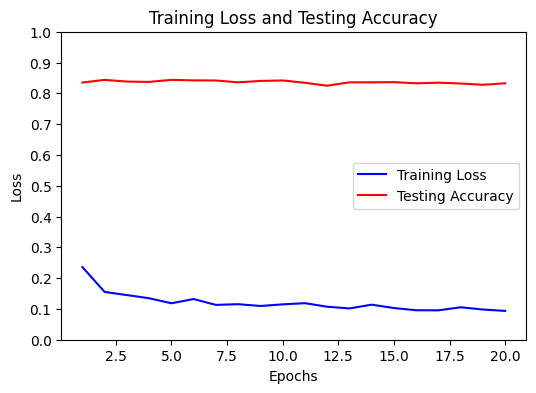

In [15]:
graph_loss_accuracy(train_loss_ls, val_accuracy_ls)

#### Evaluate

In [16]:
# for ResNet
model.eval()

with torch.no_grad():
    train_prediction = model(X_tensor)

In [17]:
train_pred_labels = (train_prediction > 0.5).int()
print(classification_report(train_pred_labels, label))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     16595
           1       0.69      0.80      0.74      4518

    accuracy                           0.88     21113
   macro avg       0.81      0.85      0.83     21113
weighted avg       0.89      0.88      0.88     21113



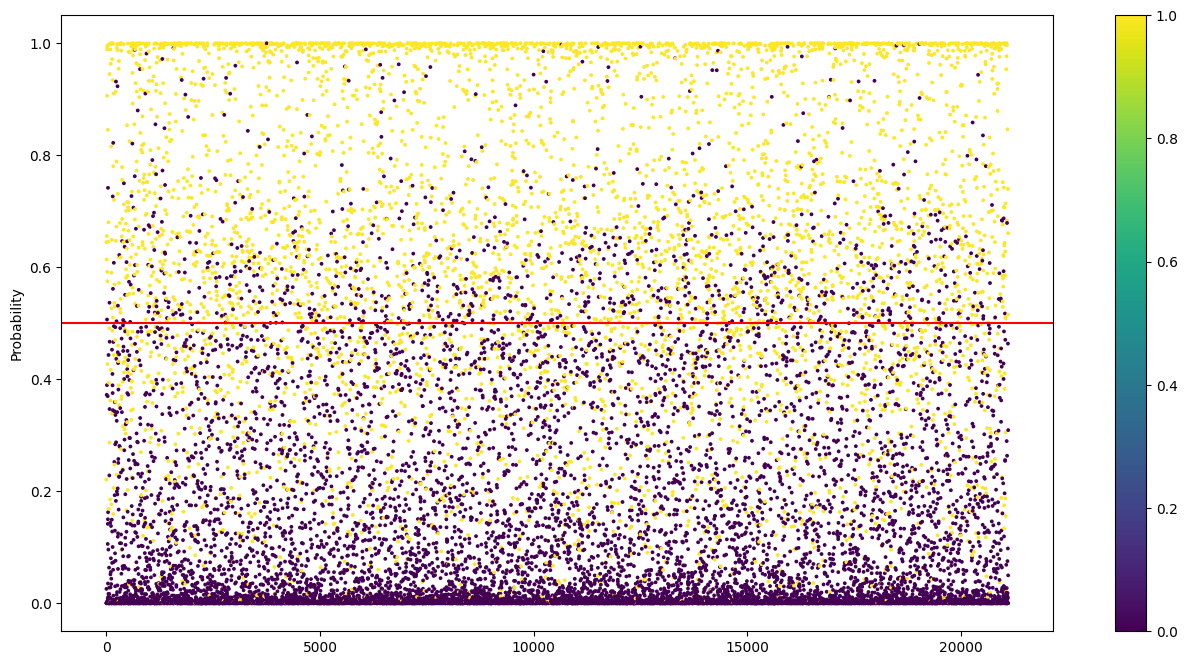

In [18]:
plt.figure(figsize=(16,8))
plt.scatter(range(len(train_prediction)), train_prediction, c=label['income'].values, s=3)
plt.axhline(y=threshold, color='red')
plt.ylabel('Probability')
plt.colorbar()
plt.show()

In [19]:
# for Testing
model.eval()

with torch.no_grad():
    test_prediction = model(X_holdout_tensor)

In [20]:
test_pred_labels = (test_prediction > 0.5).int()
print(classification_report(test_pred_labels, label_holdout))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      7139
           1       0.60      0.72      0.66      1910

    accuracy                           0.84      9049
   macro avg       0.76      0.80      0.78      9049
weighted avg       0.85      0.84      0.85      9049



In [21]:
accuracy_score(test_pred_labels, label_holdout)

0.8404243562824621

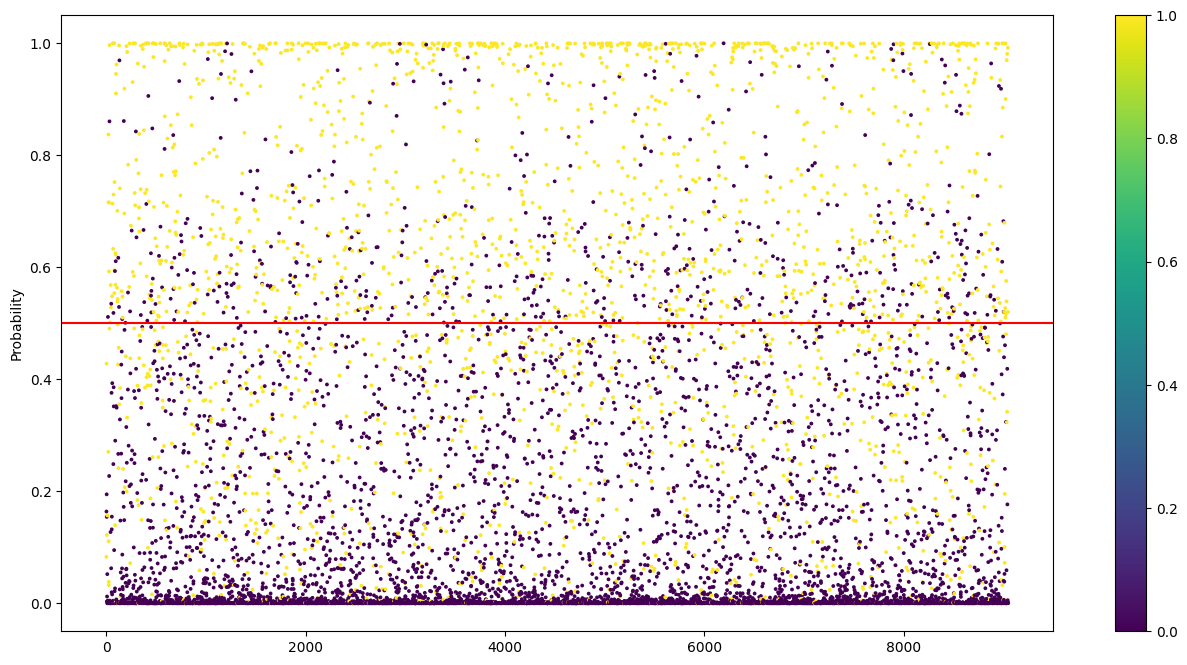

In [22]:
plt.figure(figsize=(16,8))
plt.scatter(range(len(test_prediction)), test_prediction, c=label_holdout['income'].values, s=3)
plt.axhline(y=threshold, color='red')
plt.ylabel('Probability')
plt.colorbar()
plt.show()

#### New Embeds

In [23]:
# retrieve the embeddings from the last layer before classification
outputs = []

def hook(module, input, output):
    outputs.append(output)

handle = model.model.avgpool.register_forward_hook(hook)

model.eval()

with torch.no_grad():
    model(X_tensor)

embeddings = torch.flatten(outputs[0], start_dim=1)

handle.remove()

In [ ]:
# reduce dimensionality using umap for training
n = 2
umap_embeds = UMAP(n_neighbors=15, n_components=n, min_dist=0.3,random_state=random_state)
umap_embeds_result = umap_embeds.fit_transform(embeddings)

model_embeds = KMeans(n_clusters = 2, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = random_state)

model_embeds.fit(umap_embeds_result)

labels_embeds = graph_kmeans(model_embeds, umap_embeds_result)
get_pred_stats(label['income'].values, labels_embeds)

In [ ]:
# Plot the clusters
plt.scatter(umap_embeds_result[:, 0], umap_embeds_result[:, 1], c=label.values, s=2)

#Plotting the centroids of the clusters
plt.scatter(model_embeds.cluster_centers_[:, 0], 
           model_embeds.cluster_centers_[:,1], s = 30, 
            c = 'red', label = 'Centroide')

plt.title('K-means Clustering with UMAP')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
# for testing 

# retrieve the embeddings from the last layer before classification
outputs = []

def hook(module, input, output):
    outputs.append(output)

handle = model.model.avgpool.register_forward_hook(hook)

model.eval()

with torch.no_grad():
    model(X_holdout_tensor)

embeddings = torch.flatten(outputs[0], start_dim=1)

handle.remove()



umap_embeds_result = umap_embeds.transform(embeddings)

labels_embeds = graph_kmeans(model_embeds, umap_embeds_result)
get_pred_stats(label_holdout['income'].values, labels_embeds)

In [ ]:
# Plot the clusters
plt.scatter(umap_embeds_result[:, 0], umap_embeds_result[:, 1], c=label_holdout.values, s=2)

#Plotting the centroids of the clusters
plt.scatter(model_embeds.cluster_centers_[:, 0], 
           model_embeds.cluster_centers_[:,1], s = 30, 
            c = 'red', label = 'Centroide')

plt.title('K-means Clustering with UMAP')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()